# Personal Information
Name: **Sanne van den Berg**

StudentID: **13460250**

Email: [**sanne.van.den.berg2@student.uva.nl**](sanne.van.den.berg2@student.uva.nl)

Submitted on: **22.03.2024**

# Data Context
**This project uses a dataset consisting of pages from annual reports from a variety of organizations subject to the Wet Normering Topinkomens (WNT) regulations in the Netherlands. The WNT is a legislative framework designed to cap incomes within the public and semi-public sectors, ensuring transparency and accountability of their top officials. The annual reports in this dataset are critical for assessing compliance with WNT guidelines, as they contain detailed information about these organizations.**

**The dataset was formed through an extensive web scraping operation, targeting official organization websites and other websites that present financial disclosures and reports. The web scraping tool was specifically designed to navigate these sources, identifying and extracting annual reports. For the current analysis, the documents that contain a WNT table are included, and the scraped documents that don't are left out. This ensures the inclusion of documents pertinent to the study of top income regulations and their impact on organizational transparency and governance. These documents offer useful information across diverse sectors, providing information about organizational compliance with regulatory frameworks.**

# Data Description

**The used documents contain certain pages from the annual report of these organizations. At first, these pages include the surrounding pages with WNT tables, since they are the most useful for WNT employees to confirm compliance and are the pages that are used at this moment. However, as explained in this notebook, the textual data from these pages don't conform to the primary goal of the current research, which is to determine the organization that the annual report is about. Therefore, a new dataset is created halfway this EDA, to enable the use of the first five pages of the annual reports, since these are more relevant for the organization determination.**

**This exploratory data analysis (EDA) provides a foundational understanding of the annual report dataset, showing its structure, content variability, and compliance-related features in line with the Wet Normering Topinkomens (WNT) regulations. Below, I will delve into the dataset's characteristics, using visual and statistical tools to dissect its complexities.**


<!-- Furthermore, you can insert images such as your data aggregation diagrams like this:

![image](example.png) -->

### Preparations

Let's import the necessary libraries.

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import PyPDF2
from PyPDF2 import PdfReader, errors
from pdfminer.high_level import extract_text
from collections import defaultdict
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
import seaborn as sns
import matplotlib.pyplot as plt
import re
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import seaborn as sns
from langdetect import detect

import requests
from io import BytesIO
from tqdm import tqdm
import openpyxl



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eSann\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eSann\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data Loading

Loading the data now only includes the directory, because we need to do text extraction before we can actually use the data.

In [2]:
directory = 'Wel_WNT_2020'

### Text Extraction

The text from the annual reports is extracted so it can be used for analysis. Two methods of text extraction are compared: PyPDF2 and PDFMiner. This step is necessary for all descriptives as well.

#### Text Extraction with PyPDF2

In [3]:
organization_names = []
annual_report_texts = []

# Iterate through each folder (organization) in the directory
for org_folder in os.listdir(directory):
    org_folder_path = os.path.join(directory, org_folder)
    
    if os.path.isdir(org_folder_path):  # Ensure it's a folder
        # Iterate through PDF files in the organization folder
        for pdf_file in os.listdir(org_folder_path):
            if 'Wel WNT' in pdf_file and pdf_file.endswith('.pdf'):
                pdf_file_path = os.path.join(org_folder_path, pdf_file)
                
                # Use PyPDF2 to extract text
                try:
                    pdf_reader = PdfReader(pdf_file_path)
                    text = ''
                    for page in pdf_reader.pages:
                        text += page.extract_text() + ' '  # Extract text and add a space between pages
                        
                    # Append the extracted text and organization name to the lists
                    annual_report_texts.append(text)
                    organization_names.append(org_folder)
                    
                except Exception as e:
                    print(f"Failed to process {pdf_file_path}: {e}")
                
                break  # Stop after finding the first matching PDF in the folder

# Create a DataFrame to hold the organization names and their corresponding extracted texts
pypdf_text = pd.DataFrame({'Organization Name': organization_names, 'Annual Report Text': annual_report_texts})

print(pypdf_text[:10])

Failed to process Wel_WNT_2020\211 - Gemeente Amstelveen\1. Wel WNT.pdf: list index out of range


unknown widths : 
[0, IndirectObject(64, 0, 1379664439952)]
unknown widths : 
[0, IndirectObject(75, 0, 1379664439952)]
unknown widths : 
[0, IndirectObject(81, 0, 1379664439952)]
unknown widths : 
[0, IndirectObject(87, 0, 1379664439952)]
unknown widths : 
[0, IndirectObject(93, 0, 1379664439952)]
unknown widths : 
[0, IndirectObject(101, 0, 1379664439952)]
unknown widths : 
[0, IndirectObject(107, 0, 1379664439952)]


                                   Organization Name  \
0                                0 - ABG-organisatie   
1  10 - Agrarische Natuur- en Landschapsverenigin...   
2                                    100 - Dunea N.V   
3                      1000 - Stichting Cultuur Oost   
4                 1006 - Stichting Dagopvang Utrecht   
5   1008 - Stichting Dans- en Muziekcentrum Den Haag   
6                        1009 - Stichting De Arkduif   
7                                         101 - Duo+   
8  1010 - Stichting De Balie Centrum voor Theater...   
9     1014 - Stichting de Bibliotheek Midden-Brabant   

                                  Annual Report Text  
0  Dit document heeft:\nWel WNT\nOrganisatie: \nA...  
1  Dit document heeft:\nWel WNT\nOrganisatie: \nA...  
2  Dit document heeft:\nWel WNT\nOrganisatie: \nD...  
3  Dit document heeft:\nWel WNT\nOrganisatie: \nS...  
4  Dit document heeft:\nWel WNT\nOrganisatie: \nS...  
5  Dit document heeft:\nWel WNT\nOrganisatie: \nS... 

#### Text Extraction with PDFMiner

In [4]:
organization_names = []
annual_report_texts = []

# Iterate through each folder (organization)
for org_folder in os.listdir(directory):
    org_folder_path = os.path.join(directory, org_folder)
    if os.path.isdir(org_folder_path):
        # Iterate through PDF files in the organization folder
        for pdf_file in os.listdir(org_folder_path):
            if pdf_file.endswith('.pdf') and 'Wel WNT' in pdf_file:
                pdf_file_path = os.path.join(org_folder_path, pdf_file)
                # Extract text from the first PDF file containing 'Wel WNT' in its name
                text = extract_text(pdf_file_path)
                if text:
                    # Append organization name and annual report text to the lists
                    organization_names.append(org_folder)
                    annual_report_texts.append(text)
                    break  # Stop searching for more files once text is extracted

# Create the DataFrame with organization name and annual report text
pdfminer_text = pd.DataFrame({'Organization Name': organization_names, 'Annual Report Text': annual_report_texts})

pdfminer_text['Index'] = pdfminer_text['Organization Name'].str.split(' - ').str[0].astype(int)
pdfminer_text.set_index('Index', inplace=True)

print(pdfminer_text[:10])

                                       Organization Name  \
Index                                                      
0                                    0 - ABG-organisatie   
10     10 - Agrarische Natuur- en Landschapsverenigin...   
100                                      100 - Dunea N.V   
1000                       1000 - Stichting Cultuur Oost   
1006                  1006 - Stichting Dagopvang Utrecht   
1008    1008 - Stichting Dans- en Muziekcentrum Den Haag   
1009                         1009 - Stichting De Arkduif   
101                                           101 - Duo+   
1010   1010 - Stichting De Balie Centrum voor Theater...   
1014      1014 - Stichting de Bibliotheek Midden-Brabant   

                                      Annual Report Text  
Index                                                     
0      Dit document heeft:\n\nWel WNT\n\nOrganisatie:...  
10     Dit document heeft:\n\nWel WNT\n\nOrganisatie:...  
100    Dit document heeft:\n\nWel WNT\n\nOr

Text extraction using PDFminer took about 3x longer than when using PyPDF2. When further inspecting the data, there seems no other significant difference between the two results of text. Therefore, in the remainder of this notebook, the text extracted by PyPDF2 will be used.

In [5]:
df = pypdf_text
print(df[:10])

                                   Organization Name  \
0                                0 - ABG-organisatie   
1  10 - Agrarische Natuur- en Landschapsverenigin...   
2                                    100 - Dunea N.V   
3                      1000 - Stichting Cultuur Oost   
4                 1006 - Stichting Dagopvang Utrecht   
5   1008 - Stichting Dans- en Muziekcentrum Den Haag   
6                        1009 - Stichting De Arkduif   
7                                         101 - Duo+   
8  1010 - Stichting De Balie Centrum voor Theater...   
9     1014 - Stichting de Bibliotheek Midden-Brabant   

                                  Annual Report Text  
0  Dit document heeft:\nWel WNT\nOrganisatie: \nA...  
1  Dit document heeft:\nWel WNT\nOrganisatie: \nA...  
2  Dit document heeft:\nWel WNT\nOrganisatie: \nD...  
3  Dit document heeft:\nWel WNT\nOrganisatie: \nS...  
4  Dit document heeft:\nWel WNT\nOrganisatie: \nS...  
5  Dit document heeft:\nWel WNT\nOrganisatie: \nS... 

### Initial Data Overview

Including a preliminary look at the dataset's structure: its size, the presence of missing values, and the data types of its variables.

In [6]:
# How many instances, how many variables
print("Number of instances:", df.shape[0])
print("Number of variables:", df.shape[1])

# Number of missing values for each variable
print("Number of missing values for each variable:")
print(df.isnull().sum())

# Type of each variable
print("Type of each variable:")
print(df.dtypes)

Number of instances: 1212
Number of variables: 2
Number of missing values for each variable:
Organization Name     0
Annual Report Text    0
dtype: int64
Type of each variable:
Organization Name     object
Annual Report Text    object
dtype: object


### Tokenization

Let's tokenize the text by lowering the words, removing stopwords, and removing digits and words containing one letter or only punctuation marks.

In [7]:
# Initialize an empty list to store all words
all_words = []

# Tokenize the text using NLTK
for text in df['Annual Report Text']:
    words = nltk.word_tokenize(text.lower())
    all_words.extend(words)

stop_words = set(stopwords.words('dutch'))

# Filter out words containing only punctuation marks and stop words
filtered_words = [
    word.lower() for word in all_words 
    if not any(char.isdigit() for char in word)  # Exclude words containing digits
    and len(word) > 1  # Exclude single-character words
    and word not in stop_words  # Exclude stop words
    and not all(char in string.punctuation for char in word)  # Exclude words containing only punctuation marks
]


### Text length, vocabulary size, and Hapax count

Next, let's look at the text lengths, the vocabulary size, and the hapax count. A hapax refers to a word that occurs only once within a particular document. The term "hapax count" refers to the total number of hapaxes present in a dataset.

In [8]:
# Calculations about text lengths
text_lengths = df['Annual Report Text'].apply(len)
print("Maximum text length:", text_lengths.max())
print("Minimum text length:", text_lengths.min())
print("Average text length:", sum(text_lengths) / len(text_lengths))
print("Standard deviation of text length:", np.std(text_lengths))

print("Vocabulary size:", len(set(filtered_words)))

# Calculate hapax count
word_counts = Counter(filtered_words)
print("Hapax count:", sum(1 for word, count in word_counts.items() if count == 1))

Maximum text length: 25767
Minimum text length: 1459
Average text length: 7874.555280528053
Standard deviation of text length: 3047.734229187733
Vocabulary size: 38783
Hapax count: 17402


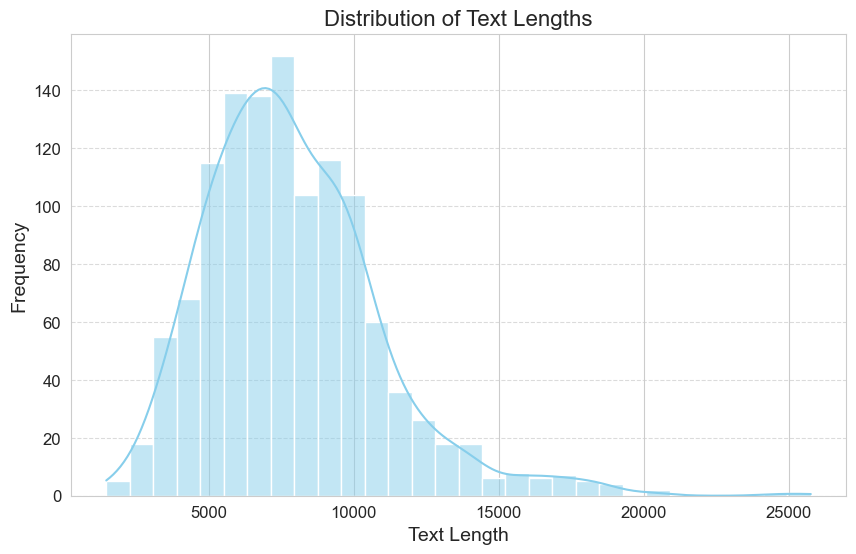

In [9]:
# Visualize the distribution of text lengths
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(text_lengths, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Text Lengths', fontsize=16)
plt.xlabel('Text Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Word Frequency Analysis

To get some insights into the words with a high frequency, we can use the word count from the hapax count and select the most common ones.

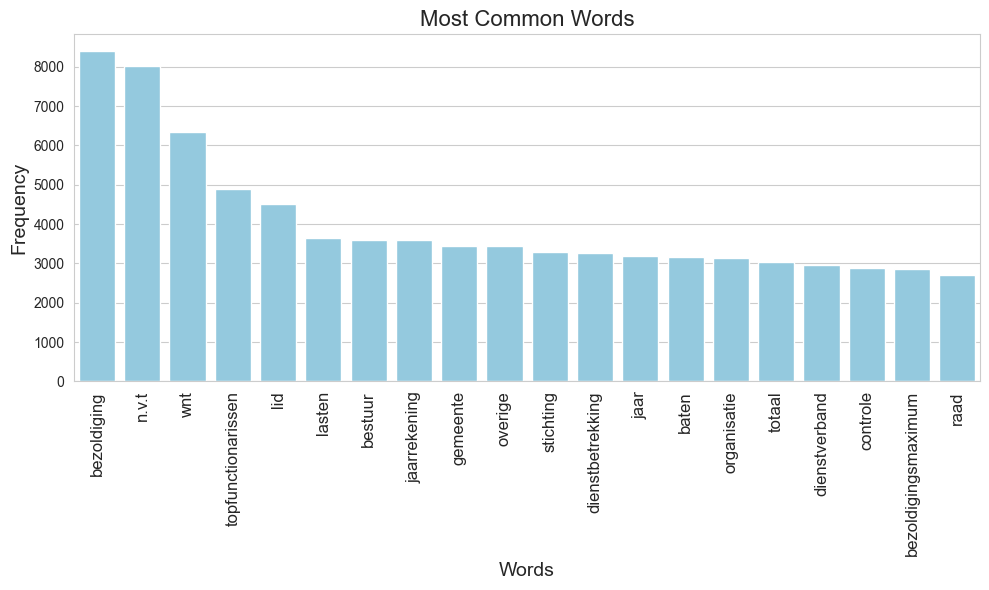

In [10]:
# small_df = df[:30]

# Most common words
common_words = word_counts.most_common(20)
common_words_df = pd.DataFrame(common_words, columns=['Words', 'Frequency'])

# Plot the most common words
plt.figure(figsize=(10, 6))
sns.barplot(x='Words', y='Frequency', data=common_words_df, color='skyblue')  # Set color to skyblue
plt.xticks(rotation=90, fontsize=12)  # Rotate labels vertically
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Most Common Words', fontsize=16)
plt.tight_layout()
plt.show()

Additionally, lets look at the most common combinations of two words (bigrams) and of three words (trigrams).

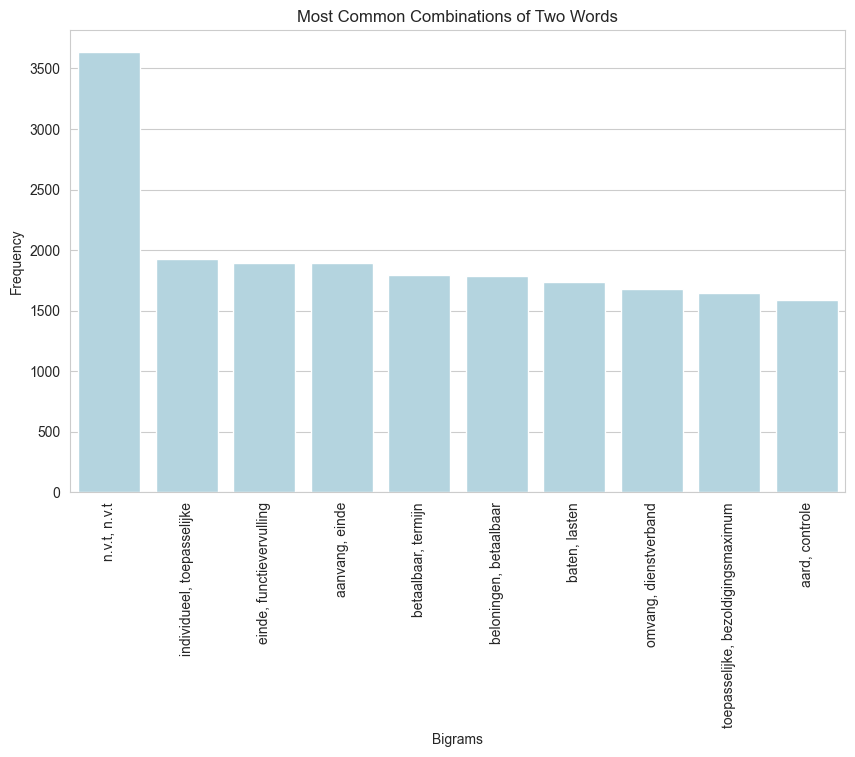

In [11]:
# Bigrams of the filtered words
bigrams = list(nltk.bigrams(filtered_words))

# Calculate the frequency of each bigram
bigram_dist = nltk.FreqDist(bigrams)

# Get most common bigrams
result_bigrams = pd.DataFrame(bigram_dist.most_common(10), columns=['Bigram', 'Frequency'])

# Extract individual words from the tuples in the 'Bigram' column
result_bigrams['Bigram'] = result_bigrams['Bigram'].apply(lambda x: ', '.join(x))

# Plot the most common bigrams
plt.figure(figsize=(10, 6))
sns.barplot(x='Bigram', y='Frequency', data=result_bigrams, color='lightblue')
plt.xticks(rotation=90)
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.title('Most Common Combinations of Two Words')
plt.show()

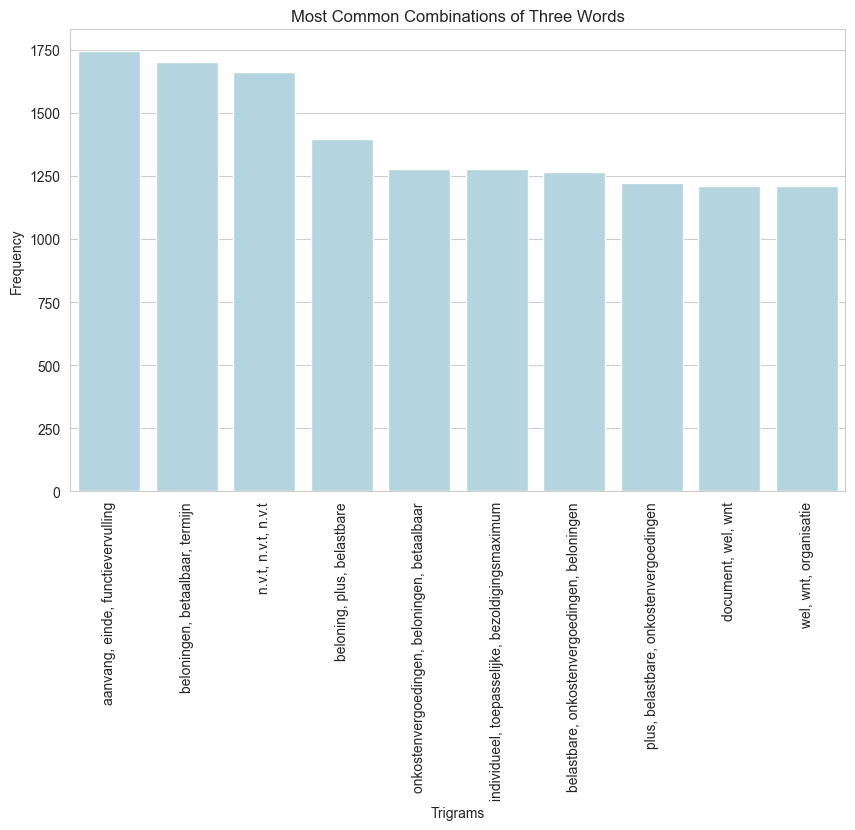

In [12]:
# Trigrams of the filtered words
trigrams = list(nltk.trigrams(filtered_words))
    
# Calculate the frequency of each trigram
trigram_dist = nltk.FreqDist(trigrams)
    
# Get most common trigrams
result_trigrams = pd.DataFrame(trigram_dist.most_common(10), columns=['Trigram', 'Frequency'])
result_trigrams = result_trigrams.set_index('Trigram')
    
# Extract individual words from the trigrams in the 'Trigram' column
result_trigrams.index = result_trigrams.index.map(lambda x: ', '.join(x))

# Plot the most common trigrams
plt.figure(figsize=(10, 6))
sns.barplot(x=result_trigrams.index, y='Frequency', data=result_trigrams, color='lightblue')
plt.xticks(rotation=90)
plt.xlabel('Trigrams')
plt.ylabel('Frequency')
plt.title('Most Common Combinations of Three Words')
plt.show()

### TF-IDF

TF-IDF is used for its ability to highlight the most relevant words in the annual reports. It reduces the importance of common words and emphasizes unique terms that better represent each document's content, making it useful for distinguishing the thematic elements in the dataset.

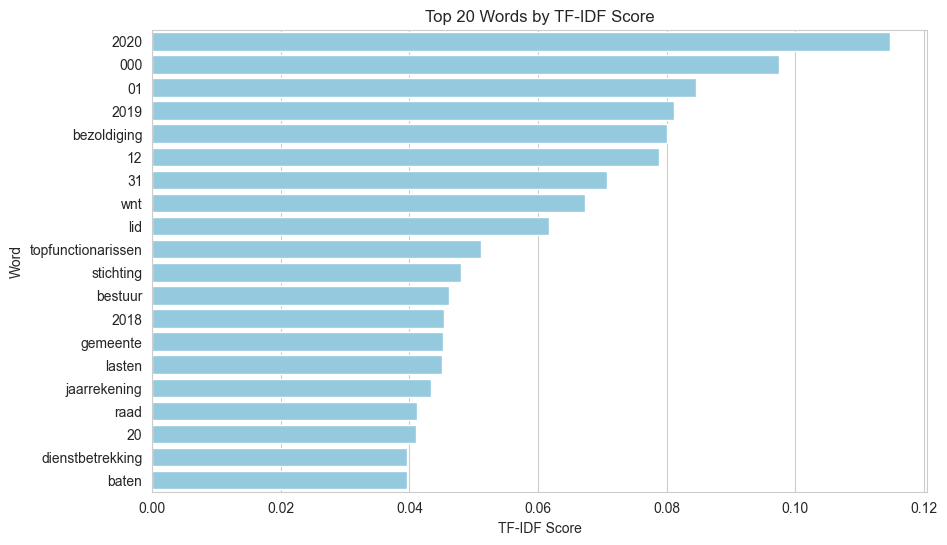

In [13]:
# Define Dutch stop words
dutch_stopwords = nltk.corpus.stopwords.words('dutch')

# df['Annual Report Text'] = df['Annual Report Text'].apply(lambda text: re.sub(r'\b\w*\d\w*\b', '', text))

# Create TF-IDF vectorizer with Dutch stop words
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words=dutch_stopwords)

# Fit and transform the text data
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Annual Report Text'])

# Get feature names (terms) from the vectorizer
terms = tfidf_vectorizer.get_feature_names_out()

# Convert TF-IDF matrix to DataFrame for easier manipulation
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=terms)

# # Display the top TF-IDF terms for each document
# for i, row in tfidf_df.iterrows():
#     top_tfidf_indices = row.argsort()[-10:][::-1]  # Top 10 TF-IDF indices
#     top_tfidf_terms = [terms[idx] for idx in top_tfidf_indices]
#     print(f"Top TF-IDF terms for document {i}: {', '.join(top_tfidf_terms)}")

# Calculate the mean TF-IDF score for each word across all documents
mean_tfidf = tfidf_matrix.mean(axis=0)

# Convert the TF-IDF scores to a list and zip it with the feature names
tfidf_scores = mean_tfidf.tolist()[0]
tfidf_word_scores = list(zip(terms, tfidf_scores))

# Sort the words by their TF-IDF scores in descending order
sorted_tfidf_word_scores = sorted(tfidf_word_scores, key=lambda x: x[1], reverse=True)

# Plot the top 20 words with the highest TF-IDF scores
top_n = 20
top_words = [word for word, score in sorted_tfidf_word_scores[:top_n]]
top_scores = [score for word, score in sorted_tfidf_word_scores[:top_n]]

# Create a DataFrame for the top words and their TF-IDF scores
top_words_df = pd.DataFrame({'Word': top_words, 'TF-IDF Score': top_scores})

# Plot the top words by TF-IDF score using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='TF-IDF Score', y='Word', data=top_words_df, color='skyblue')
plt.xlabel('TF-IDF Score')
plt.ylabel('Word')
plt.title('Top {} Words by TF-IDF Score'.format(top_n))

plt.show()

These text analyses show the presence of many WNT-related words in the extracted pages. 

## Subconclusion: Choosing the Right (and a Different) Approach

The analyses conducted thus far have consistently revealed that the significant and recurrent words closely align with the WNT tables present in the annual reports. This makes sense, because the scraper selects the five pages surrounding the found WNT tables. However, while these tables provide valuable information, the primary goal in this research is to determine the organizations from these annual reports accurately. Therefore, I have made the decision to prioritize the first five pages of the annual reports over the WNT tables. This approach is better suited for organization determination as it captures a broader spectrum of content, allowing for a more comprehensive analysis of the documents. In the analyses below, I will select these five pages and analyze them the same way I did before with the WNT pages.

### Selecting and Extracting Text from the First Five Pages

First, we need to scrape the new pages and extract the text from those. PyPDF2 is used for this text extraction, since it showed the most promising result for the WNT pages as well.

In [3]:
indeces = []
organization_names = []
urls = []
texts = []


# Iterate through each folder (organization)
for org_folder in tqdm(os.listdir(directory)):
    org_folder_path = os.path.join(directory, org_folder)
    if os.path.isdir(org_folder_path):
        # Iterate through PDF files in the organization folder
        for pdf_file in os.listdir(org_folder_path):
            if pdf_file.endswith('.pdf') and 'Wel WNT' in pdf_file:
                pdf_file_path = os.path.join(org_folder_path, pdf_file)
                # Extract text from the first PDF file containing 'Wel WNT' in its name
                report_page = PdfReader(pdf_file_path, strict=False).pages[0]
                url = ''
                pdf_reader = False
                try:
                    url = report_page.extract_text().split('\n')[8]
                    HTTPresponse = requests.get(url)
                    # Create a BytesIO object from the PDF content
                    bytes_stream = BytesIO(HTTPresponse.content)

                    # Create a PdfReader object with the PDF content stream
                    pdf_reader = PdfReader(bytes_stream)
                except (requests.HTTPError, requests.ConnectionError, requests.exceptions.ChunkedEncodingError,
                        requests.exceptions.RetryError, requests.exceptions.ContentDecodingError, requests.exceptions.SSLError,
                        requests.exceptions.TooManyRedirects, requests.exceptions.SSLError, requests.exceptions.BaseHTTPError,
                        requests.exceptions.ConnectTimeout, requests.exceptions.FileModeWarning, requests.exceptions.RequestException,
                        errors.PdfReadError, errors.EmptyFileError, errors.PdfStreamError, errors.FileNotDecryptedError):
                    pass
                if pdf_reader:
                    # Get the text from the first 5 pages
                    text_of_first_5_pages = ''.join(page.extract_text() for page in pdf_reader.pages[:5])

                    # Append organization data to lists
                    indeces.append(org_folder.split(' - ')[0])
                    organization_names.append(org_folder)
                    urls.append(url)
                    texts.append(text_of_first_5_pages)
                    break  # Stop searching for more files once text is extracted

# Create the DataFrame with organization name and annual report text
dfn = pd.DataFrame({'Index': indeces,
                   'Organization Name': organization_names,
                   'Urls': urls,
                   'Text': texts
                   })

# Change values 1, 10, 100 into 0001, 0010, 0100 etc.
dfn.index = dfn.index.map(lambda x: f"{x:04}")

dfn.set_index('Index', inplace=True)

dfn.sort_values(by='Index')

print(dfn[:10])

100%|██████████| 1213/1213 [20:02<00:00,  1.01it/s]   


                                       Organization Name  \
Index                                                      
0                                    0 - ABG-organisatie   
100                                      100 - Dunea N.V   
1000                       1000 - Stichting Cultuur Oost   
1006                  1006 - Stichting Dagopvang Utrecht   
1008    1008 - Stichting Dans- en Muziekcentrum Den Haag   
1010   1010 - Stichting De Balie Centrum voor Theater...   
1015             1015 - Stichting de Bibliotheek Utrecht   
1018             1018 - Stichting de Bibliotheek Z-O-U-T   
1019   1019 - Stichting De Boei, Sociaal Werk Bunschoten   
102            102 - Duurzaam Bedrijf Haarlemmermeer B.V   

                                                    Urls  \
Index                                                      
0      https://www.abg.nl/documents/Jaarstukken_ABG_2...   
100    https://www.dunea.nl/over-dunea/-/media/bestan...   
1000   https://www.lkca.nl/wp-content/u

In [ ]:
dfn.to_csv('data.csv')

In [15]:
print(dfn['Text'][:10])

Index
0        \n \n \n \n \n \n \n \n \n \n \nJAARSTUKKEN  ...
100     Jaarverslag 2020GeïntegreerdDunea in een oogop...
1000    Jaarverslag LKCA 2020 1 Jaarverslag 2020  \n  ...
1006    RAPPORT INZAKE HET JAARVERSLAG\n Stichting Sam...
1008    Jaarverslag\n20152\n© Rahi Rezvani – The lost ...
1010    1\nODE AAN DE ONTMOETING\nJAARVERSLAG 2019\n2“...
1015    de Bibliotheek Utrecht Jaarverslag 20181\nde B...
1018    Jaarverslaggeving 2018\nStichting de Bibliothe...
1019    Jaarverslaggeving\n2020\nStichting De Boei, So...
102     Adres:\nPostbus 511\n2003 PB Haarlem\nFoto oms...
Name: Text, dtype: object


### Initial Data Overview

Again, a preliminary look at the dataset's structure: its size, the presence of missing values, and the data types of its variables.

In [16]:
# How many instances, how many variables
print("Number of instances:", dfn.shape[0])
print("Number of variables:", dfn.shape[1])

# Number of missing values for each variable
print("Number of missing values for each variable:")
print(dfn.isnull().sum())

# Type of each variable
print("Type of each variable:")
print(dfn.dtypes)

Number of instances: 910
Number of variables: 3
Number of missing values for each variable:
Organization Name    0
Urls                 0
Text                 0
dtype: int64
Type of each variable:
Organization Name    object
Urls                 object
Text                 object
dtype: object


Here we see that the number of instances has declined from 1212 to 910. This can be explained with the fact that the urls that were used in the scraping process no longer exist for some documents, resulting in the inability to select the first five pages from these documents. This means the organization has taken the annual report offline, which may be interesting for WNT employees to look into, as these are mandatory to publish.

### Tokenization

Let's tokenize the text again by lowering the words, removing stopwords, and removing digits and words containing one letter or only punctuation marks.

In [17]:
# Initialize an empty list to store all words
all_words = []

# Tokenize the text using NLTK
for text in dfn['Text']:
    words = nltk.word_tokenize(text.lower())
    all_words.extend(words)

stop_words = set(stopwords.words('dutch'))

# Filter out words containing only punctuation marks and stop words
filtered_words = [
    word.lower() for word in all_words 
    if not any(char.isdigit() for char in word)  # Exclude words containing digits
    and len(word) > 1  # Exclude single-character words
    and word not in stop_words  # Exclude stop words
    and not all(char in string.punctuation for char in word)  # Exclude words containing only punctuation marks
]


### Text length, vocabulary size, and Hapax count

Next, let's look at the text lengths, the vocabulary size, and the hapax count. 

In [18]:
# Calculations about text lengths
text_lengths = dfn['Text'].apply(len)
print("Maximum text length:", text_lengths.max())
print("Minimum text length:", text_lengths.min())
print("Average text length:", sum(text_lengths) / len(text_lengths))
print("Standard deviation of text length:", np.std(text_lengths))

print("Vocabulary size:", len(set(filtered_words)))

# Calculate hapax count
word_counts = Counter(filtered_words)
print("Hapax count:", sum(1 for word, count in word_counts.items() if count == 1))

Maximum text length: 38344
Minimum text length: 689
Average text length: 8937.35054945055
Standard deviation of text length: 4158.7755271001815
Vocabulary size: 37910
Hapax count: 17008


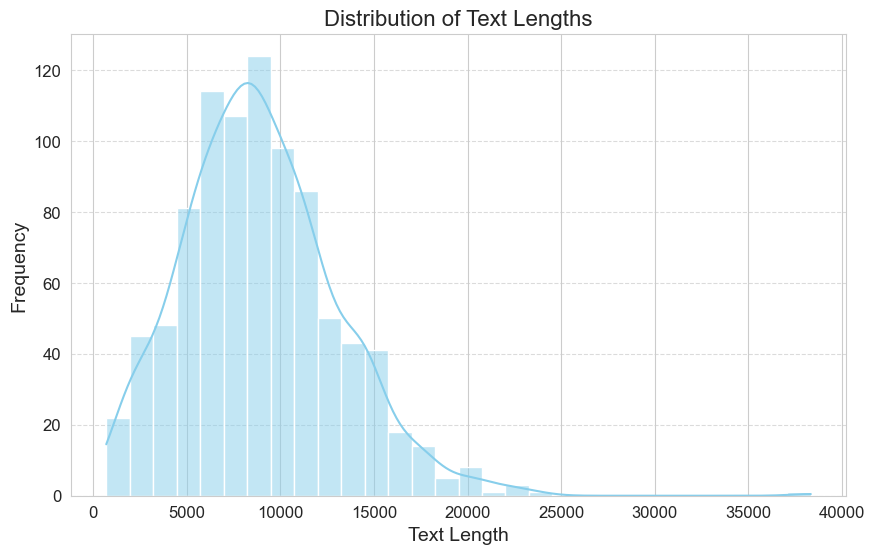

In [19]:
# Visualize the distribution of text lengths
plt.figure(figsize=(10, 6))
sns.histplot(text_lengths, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Text Lengths', fontsize=16)
plt.xlabel('Text Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Word Frequency Analysis

To get some insights into the words with a high frequency, we can use the word count from the hapax count and select the most common ones.

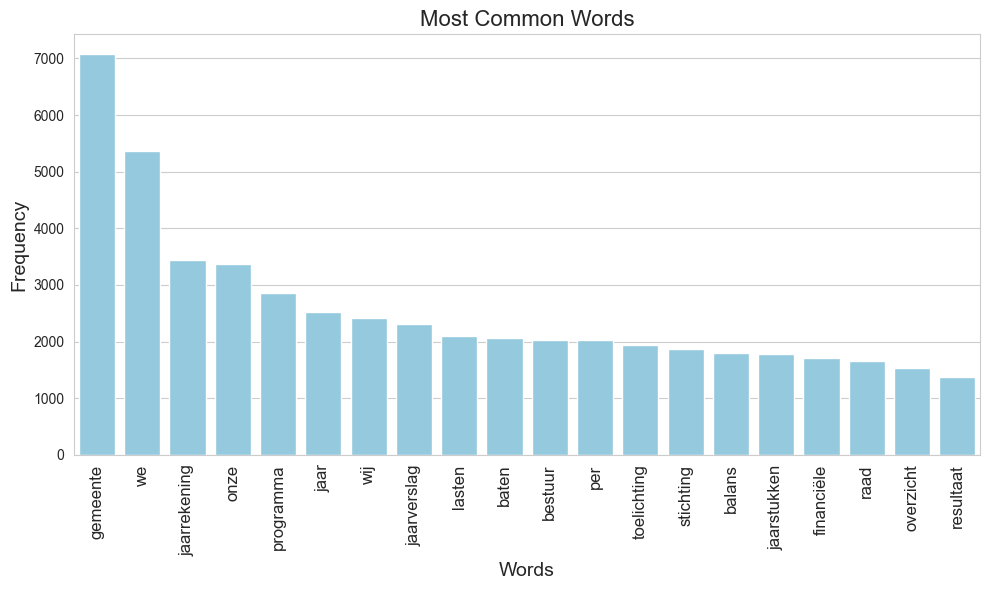

In [20]:
# small_df = df[:30]

# Most common words
common_words = word_counts.most_common(20)
common_words_df = pd.DataFrame(common_words, columns=['Words', 'Frequency'])

# Plot the most common words
plt.figure(figsize=(10, 6))
sns.barplot(x='Words', y='Frequency', data=common_words_df, color='skyblue')  # Set color to skyblue
plt.xticks(rotation=90, fontsize=12)  # Rotate labels vertically
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Most Common Words', fontsize=16)
plt.tight_layout()
plt.show()

This looks promising: more words that are about the general annual report instead of just WNT information. This looks more useful to the organization determination research.

Additionally, lets look at the most common combinations of two words (bigrams) and of three words (trigrams).

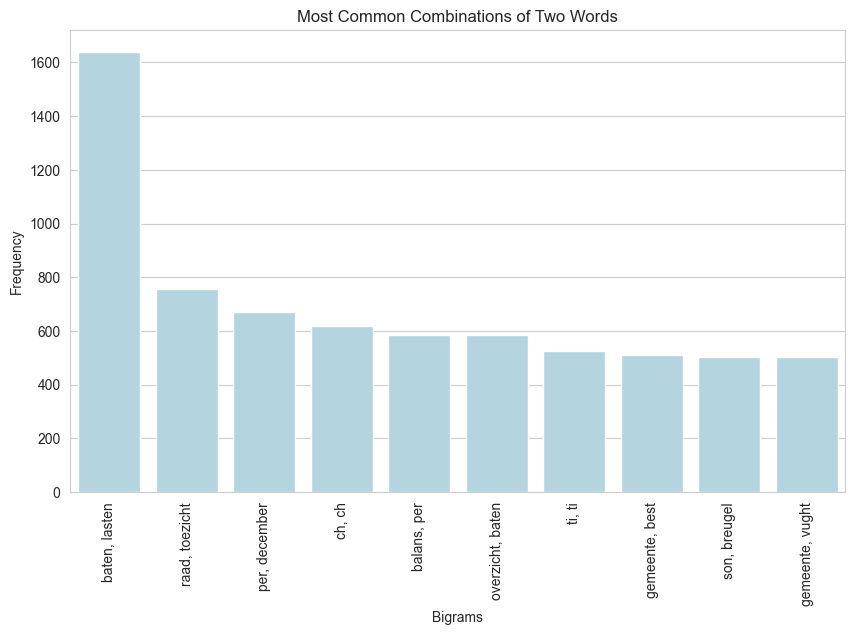

In [21]:
# Bigrams of the filtered words
bigrams = list(nltk.bigrams(filtered_words))

# Calculate the frequency of each bigram
bigram_dist = nltk.FreqDist(bigrams)

# Get most common bigrams
result_bigrams = pd.DataFrame(bigram_dist.most_common(10), columns=['Bigram', 'Frequency'])

# Extract individual words from the tuples in the 'Bigram' column
result_bigrams['Bigram'] = result_bigrams['Bigram'].apply(lambda x: ', '.join(x))

# Plot the most common bigrams
plt.figure(figsize=(10, 6))
sns.barplot(x='Bigram', y='Frequency', data=result_bigrams, color='lightblue')
plt.xticks(rotation=90)
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.title('Most Common Combinations of Two Words')
plt.show()

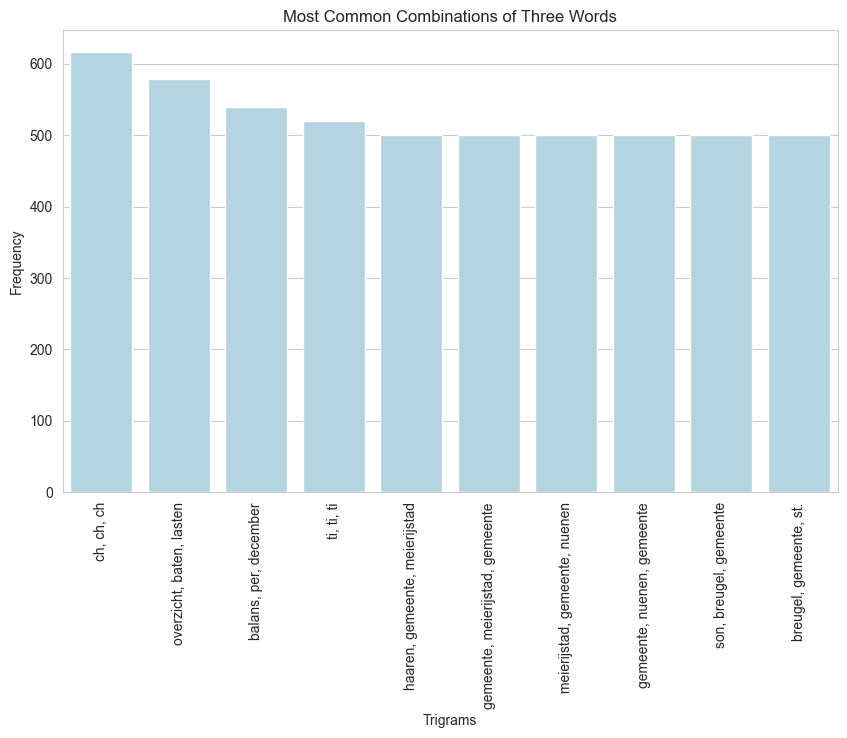

In [22]:
# Trigrams of the filtered words
trigrams = list(nltk.trigrams(filtered_words))
    
# Calculate the frequency of each trigram
trigram_dist = nltk.FreqDist(trigrams)
    
# Get most common trigrams
result_trigrams = pd.DataFrame(trigram_dist.most_common(10), columns=['Trigram', 'Frequency'])
result_trigrams = result_trigrams.set_index('Trigram')
    
# Extract individual words from the trigrams in the 'Trigram' column
result_trigrams.index = result_trigrams.index.map(lambda x: ', '.join(x))

# Plot the most common trigrams
plt.figure(figsize=(10, 6))
sns.barplot(x=result_trigrams.index, y='Frequency', data=result_trigrams, color='lightblue')
plt.xticks(rotation=90)
plt.xlabel('Trigrams')
plt.ylabel('Frequency')
plt.title('Most Common Combinations of Three Words')
plt.show()

### TF-IDF

TF-IDF is used for its ability to highlight the most relevant words in the annual reports. It reduces the importance of common words and emphasizes unique terms that better represent each document's content, making it useful for distinguishing the thematic elements in the dataset.

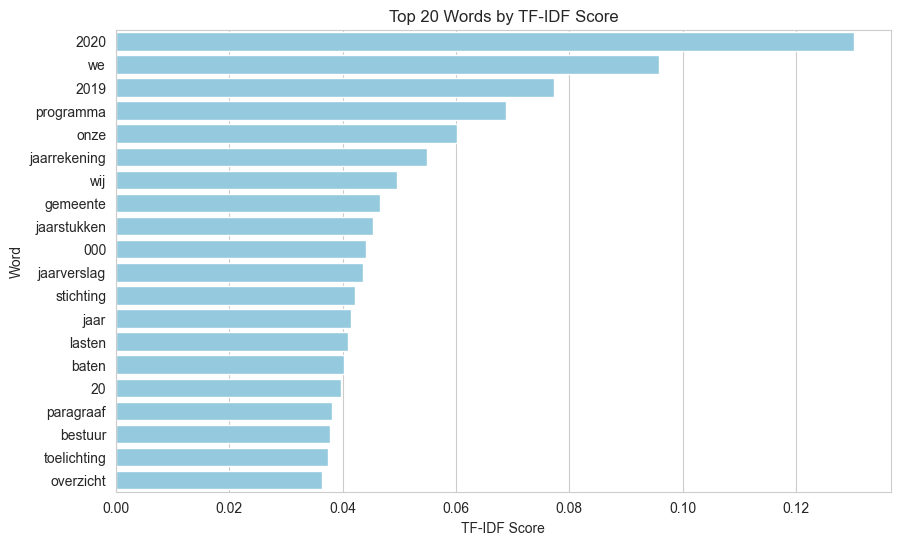

In [23]:
# Define Dutch stop words
dutch_stopwords = nltk.corpus.stopwords.words('dutch')

# Create TF-IDF vectorizer with Dutch stop words
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words=dutch_stopwords)

# Fit and transform the text data
tfidf_matrix = tfidf_vectorizer.fit_transform(dfn['Text'])

# Get feature names (terms) from the vectorizer
terms = tfidf_vectorizer.get_feature_names_out()

# Convert TF-IDF matrix to DataFrame for easier manipulation
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=terms)

# # Display the top TF-IDF terms for each document
# for i, row in tfidf_df.iterrows():
#     top_tfidf_indices = row.argsort()[-10:][::-1]  # Top 10 TF-IDF indices
#     top_tfidf_terms = [terms[idx] for idx in top_tfidf_indices]
#     print(f"Top TF-IDF terms for document {i}: {', '.join(top_tfidf_terms)}")

# Calculate the mean TF-IDF score for each word across all documents
mean_tfidf = tfidf_matrix.mean(axis=0)

# Convert the TF-IDF scores to a list and zip it with the feature names
tfidf_scores = mean_tfidf.tolist()[0]
tfidf_word_scores = list(zip(terms, tfidf_scores))

# Sort the words by their TF-IDF scores in descending order
sorted_tfidf_word_scores = sorted(tfidf_word_scores, key=lambda x: x[1], reverse=True)

# Plot the top 20 words with the highest TF-IDF scores
top_n = 20
top_words = [word for word, score in sorted_tfidf_word_scores[:top_n]]
top_scores = [score for word, score in sorted_tfidf_word_scores[:top_n]]

# Create a DataFrame for the top words and their TF-IDF scores
top_words_df = pd.DataFrame({'Word': top_words, 'TF-IDF Score': top_scores})

# Plot the top words by TF-IDF score
plt.figure(figsize=(10, 6))
sns.barplot(x='TF-IDF Score', y='Word', data=top_words_df, color='skyblue')
plt.xlabel('TF-IDF Score')
plt.ylabel('Word')
plt.title('Top {} Words by TF-IDF Score'.format(top_n))

plt.show()

### Sentiment

Lastly, let's look at the sentiment and languages in the data. I expect this to be quite neutral and mostly Dutch.

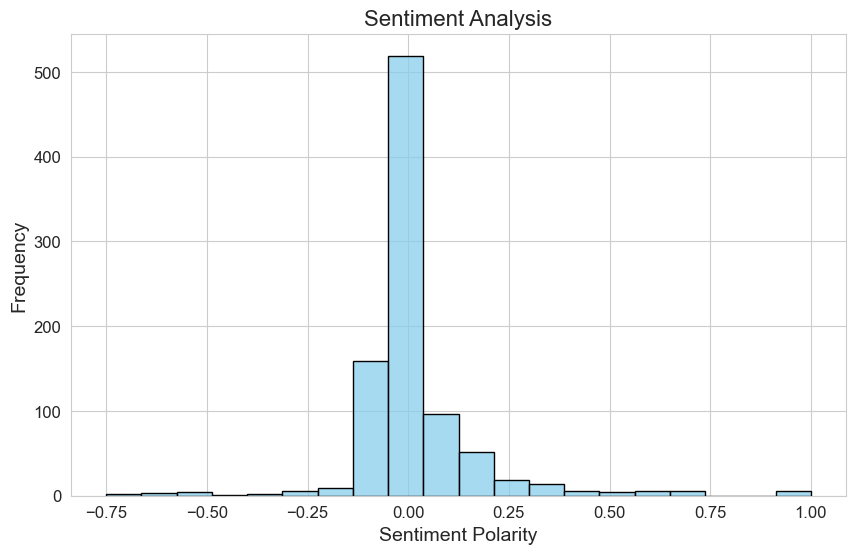

In [24]:
# Analyze sentiment for each document
sentiments = [TextBlob(document).sentiment.polarity for document in dfn['Text']]

# Plot sentiment distribution
plt.figure(figsize=(10, 6))
sns.histplot(sentiments, bins=20, color='skyblue', edgecolor='black')
plt.title('Sentiment Analysis', fontsize=16)
plt.xlabel('Sentiment Polarity', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Languages

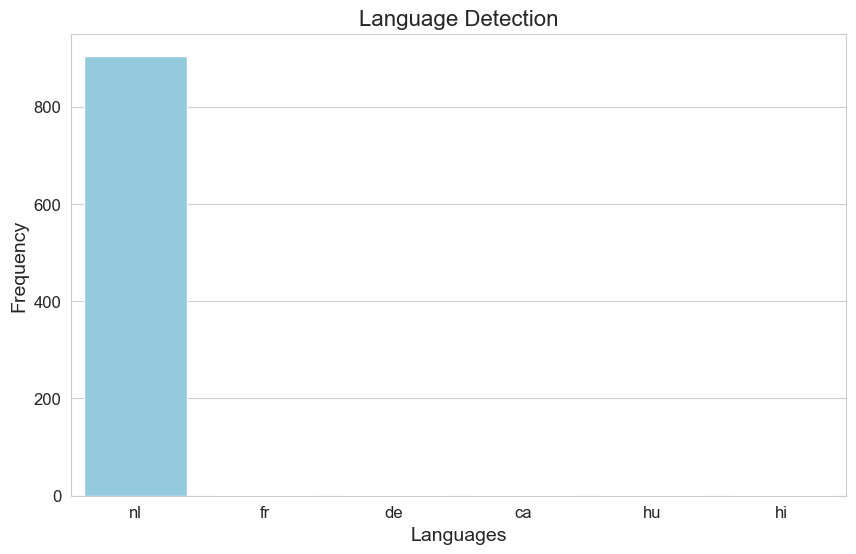

In [28]:
# Detect language for each document
languages = [detect(document) for document in dfn['Text']]

# Count the frequency of each language
language_freq = Counter(languages)

# Convert the counter to a DataFrame for plotting
language_df = pd.DataFrame({'Language': language_freq.keys(), 'Frequency': language_freq.values()})

# Plot language distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='Language', y='Frequency', data=language_df, color='skyblue')
plt.title('Language Detection', fontsize=16)
plt.xlabel('Languages', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Conclusion

The initial stages of data exploration and analysis have provided valuable insights into the nature of the extracted text from annual reports. Through text extraction using PyPDF2 and PDFMiner, it was observed that PyPDF2 gave faster results without significant differences in the extracted text quality, leading to its adoption for further analysis. Examinations of text length, vocabulary size, and hapax count showed substantial occurrences of WNT-related words in the extracted pages.

So, in pursuit of the primary goal of accurately determining organizations from annual reports, a shift was made towards prioritizing the first five pages from the annual reports over the WNT tables. This adjustment aims to capture a broader spectrum of content, facilitating a more comprehensive analysis for organization determination. As a result, the analyses on the first five pages reveal a promising mix of general and organizational-related terms, thus enhancing the potential usefulness for organization determination research.